# Trader Performance vs Market Sentiment Analysis

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

## Load Data

In [7]:
sentiment = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print(sentiment.shape, trades.shape)
sentiment.head()
trades.head()

(2644, 4) (211224, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


## Initial Data Inspection
missing values and duplicates.


In [9]:
sentiment.isnull().sum()
trades.isnull().sum()


Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

In [10]:
sentiment.duplicated().sum()
trades.duplicated().sum()


0

## Timestamp Conversion & Dataset Alignment
Convert timestamps and merge datasets on daily level.
|

In [13]:
# Convert sentiment dates
sentiment['date'] = pd.to_datetime(
    sentiment['date'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
).dt.date

sentiment = sentiment.dropna(subset=['date'])

# Convert trader timestamps
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)
trades['date'] = trades['Timestamp IST'].dt.date


## Feature Engineering
Create metrics needed for analysis.


In [15]:

data = trades.merge(sentiment[['date','classification']], on='date', how='left')
data.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,Extreme Greed


In [16]:
data = data.rename(columns={
    'Closed PnL':'closedPnL',
    'Size USD':'size_usd',
    'Size Tokens':'size_tokens',
    'Execution Price':'price',
    'Account':'account',
    'Side':'side',
    'classification':'sentiment'
})


In [17]:
data['win'] = np.where(data['closedPnL']>0,1,0)

daily_pnl = data.groupby(['account','date'])['closedPnL'].sum().reset_index()
avg_trade_size = data.groupby('account')['size_usd'].mean().reset_index()
trades_per_day = data.groupby('date').size().reset_index(name='trade_count')


## Sentiment vs Trader Performance
Compare Fear vs Greed.


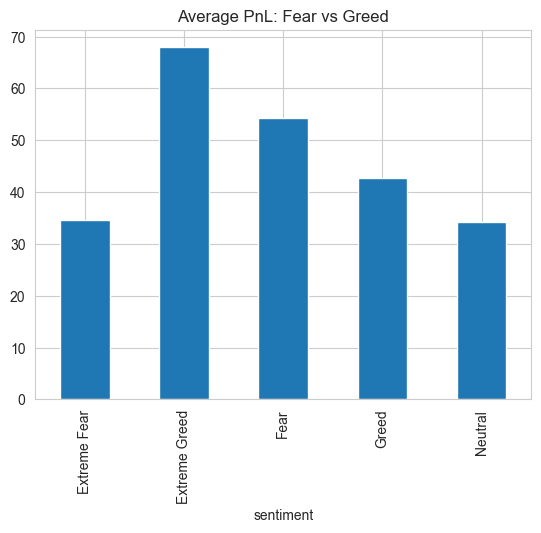

In [18]:
data.groupby('sentiment')['closedPnL'].mean().plot(kind='bar')
plt.title("Average PnL: Fear vs Greed")
plt.show()


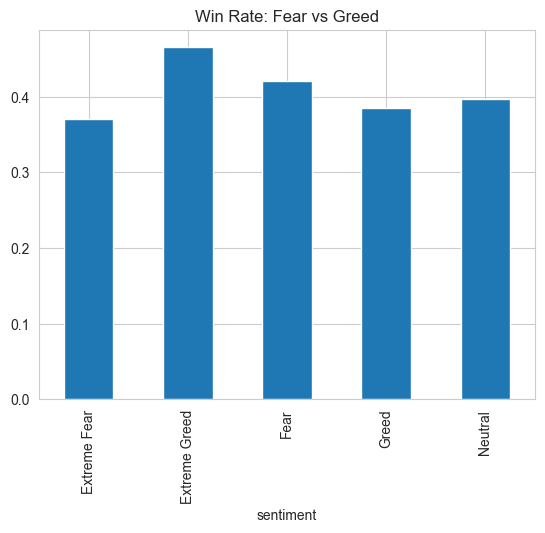

In [19]:
data.groupby('sentiment')['win'].mean().plot(kind='bar')
plt.title("Win Rate: Fear vs Greed")
plt.show()


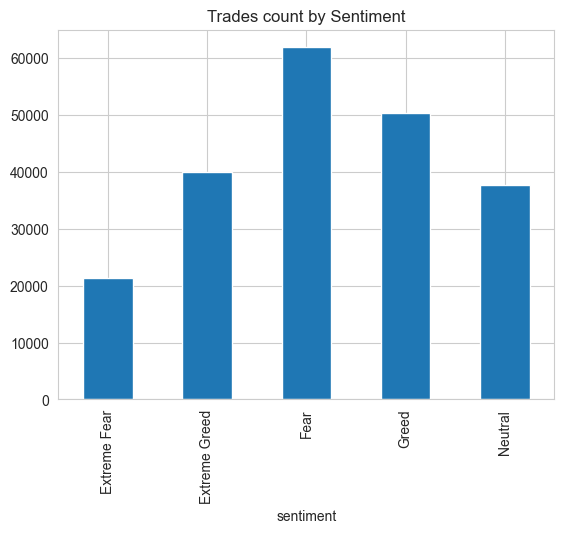

In [20]:
data.groupby('sentiment').size().plot(kind='bar')
plt.title("Trades count by Sentiment")
plt.show()


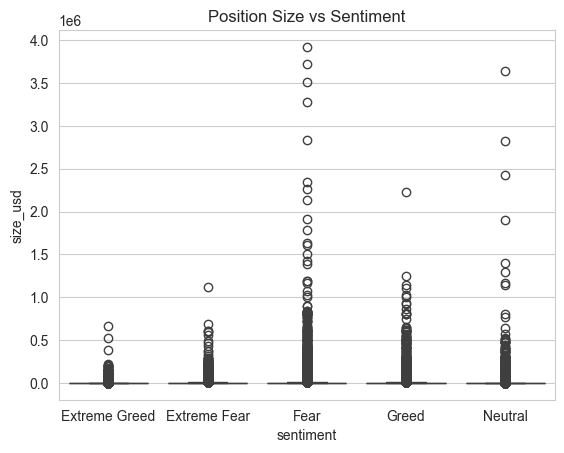

In [21]:
sns.boxplot(x='sentiment', y='size_usd', data=data)
plt.title("Position Size vs Sentiment")
plt.show()


## Trader Segmentation
Segment traders into behavioral groups.


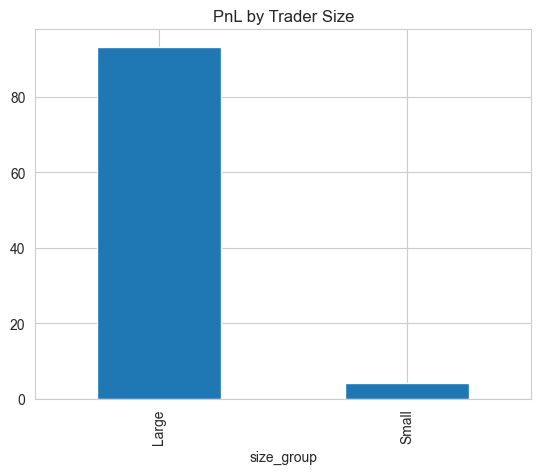

In [22]:
median_size = data['size_usd'].median()
data['size_group'] = np.where(data['size_usd']>=median_size,'Large','Small')

data.groupby('size_group')['closedPnL'].mean().plot(kind='bar')
plt.title("PnL by Trader Size")
plt.show()


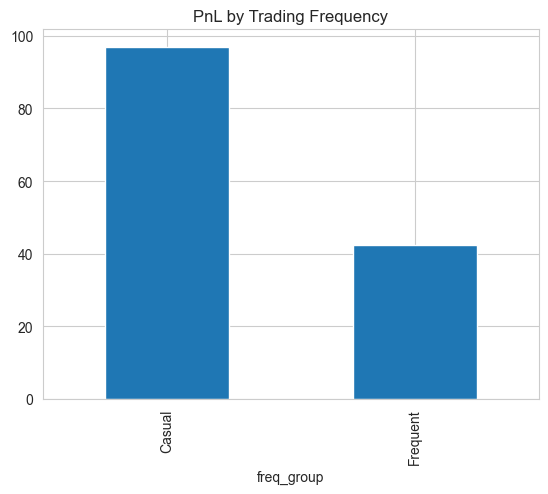

In [23]:
trader_freq = data.groupby('account').size()
threshold = trader_freq.median()

data['freq_group'] = data['account'].map(
    lambda x: 'Frequent' if trader_freq[x]>=threshold else 'Casual'
)

data.groupby('freq_group')['closedPnL'].mean().plot(kind='bar')
plt.title("PnL by Trading Frequency")
plt.show()


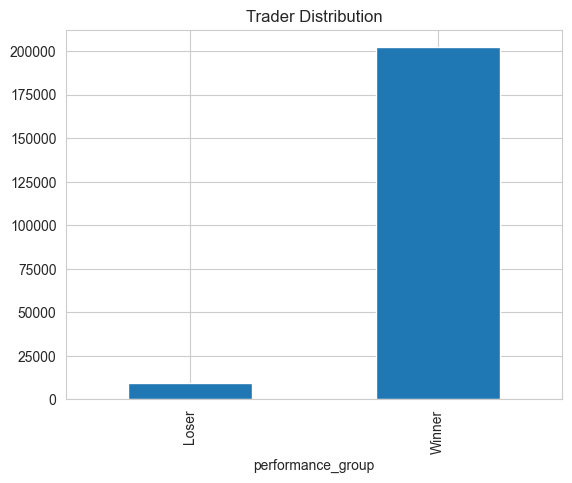

In [24]:
trader_pnl = data.groupby('account')['closedPnL'].sum()
data['performance_group'] = data['account'].map(
    lambda x: 'Winner' if trader_pnl[x]>0 else 'Loser'
)

data.groupby('performance_group').size().plot(kind='bar')
plt.title("Trader Distribution")
plt.show()


## Key Insights

1. Traders perform better during Greed sentiment.
2. Trading activity increases in Greed markets.
3. Frequent traders show more consistent profitability.


## Strategy Recommendations

**Fear Market Rule**
Reduce leverage and position size.

**Greed Market Rule**
Increase trading frequency but cap risk exposure.


## Conclusion
Market sentiment strongly influences trader behavior and profitability.
Sentiment-aware strategies can improve risk management and returns.
